In [42]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport


# data was edited by hand before
# id column was dropped
# sex was converted to numeric: M=1, F=0
# season was converted to numeric: winter=0,spring=1, summer=2, autumn=3
data = pd.read_csv('data/working_sheet.csv', sep=";",na_values=None, header=0)

# # create a report of the data
# report = ProfileReport(data)

## save the report to a file
# report.to_file("reports/original_data.html")


# create a yellow bricks radviz visualization
from yellowbrick.features import RadViz

X = data.drop(['death_aecopd'], axis=1)
y = data['death_aecopd']
visualizer = RadViz(X,y,features=X.columns, colors=['#FF0000', '#00FF00'])
# show visualization
visualizer.show()


TypeError: RadialVisualizer.__init__() got multiple values for argument 'features'

In [17]:
import matplotlib.pyplot as plt
# save svg plot for missing values per variable
missing_values = data.isnull().sum()
missing_values.plot(kind='bar')
plt.savefig('images/missing_values_before.svg', format='svg', dpi=1200)
plt.clf()

# drop all records with more than 85% missing values and no value of 1 in the death or death_aecopd column
threshold = data.shape[1] * 0.85

# get rows with death == 1 (underrepresented class). Death includes death_aecopd == 1
data['death'] = data['death'].astype(str)
rows_with_death = data[data['death'].str.contains('1')]

df = data.dropna(thresh=threshold)
# add rows with death or death_aecopd == 1 if they were dropped
df = pd.concat([df, rows_with_death]).drop_duplicates(keep='first')
# drop the first column
rows_with_death = df.iloc[:, 1:]

# save plot of how many missing values there are for each variable
missing_values = df.isnull().sum()
missing_values.plot(kind='bar')

# drop fev1 column
df = df.drop(columns=['fev1'])

plt.savefig('images/missing_values_after.svg', format='svg', dpi=1200)
plt.clf()
df.to_csv(f'data/drop_records_mv.csv', sep=';', index=False)



# generate report with dropped values
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}}, pool_size=16)
# profile.to_file(output_file="reports/drop_records_mv.html")

     Unnamed: 0 death  death_aecopd  sex  season  aecopd_12m  saturation  \
0             1     0           0.0    1       3           1        92.0   
1            26     0           0.0    1       3           0        87.0   
2            37     0           0.0    1       0           3        94.0   
3            38     0           0.0    1       3           2        92.0   
4            49     0           0.0    1       0           0        92.0   
..          ...   ...           ...  ...     ...         ...         ...   
116        1601     1           1.0    1       1           2        76.0   
117        1609     1           1.0    1       3           1        75.0   
118        1633     1           1.0    1       3           2        95.0   
119        1655     1           1.0    1       3           3        91.0   
120        1694     1           1.0    1       0           2        92.0   

       rr    sbp   dbp  ...  rural  home_care  charlson  ami  heart_failure  \
0    26.

<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn.impute import SimpleImputer
from numpy import nan
# impute missing values using a median strategy with simple imputer for the columns 5 to 29 (variables below)
# aecopd_12m saturation	rr	sbp	dbp	hr	temperature	oedema	retractions	confusion	dyspnoea_yesno	dyspnoea_mMRC	age	fev1	bmi	rural	home_care	charlson	ami	heart_failure	cbd	pad	dementia	diabetes	zero

def impute_missing_values(data):
    # define the imputer
    numeric_vars = ["saturation","rr","sbp","dbp","hr","temperature","age","bmi"]
    categorical_vars = ["oedema","retractions","confusion","dyspnoea_yesno","dyspnoea_mMRC","rural","home_care","charlson","ami","heart_failure","cbd","pad","dementia","diabetes","cancer"]
    num_imputer = SimpleImputer(missing_values=nan, strategy='median')
    cat_imputer = SimpleImputer(missing_values=nan, strategy='most_frequent')
    # fit the imputer on the dataset
    num_imputer.fit(data[numeric_vars])
    cat_imputer.fit(data[categorical_vars])
    # transform the dataset
    data[numeric_vars] = num_imputer.transform(data[numeric_vars])
    data[categorical_vars] = cat_imputer.transform(data[categorical_vars])
    return data

data = pd.read_csv("data/drop_records_mv.csv", sep=";", )
df = impute_missing_values(data)
df.to_csv(f'data/imputed_missing_values.csv', index=False, sep=';')
# import pandas_profiling
# pandas_profiling.ProfileReport(df).to_file(f'reports/imputed_values.html')

In [42]:
# scaling
data = pd.read_csv("data/imputed_missing_values.csv", sep=";")
# z-score scaling

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

# normalize only boolean and numeric variables
data.columns = ["aecopd_12m","saturation","rr","sbp","dbp","hr","temperature","age","bmi"]
df_nr = data[data.columns]
df_rest = data.drop(data.columns, axis=1)
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data[data.columns])
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= data.columns)
norm_data_zscore = concat([tmp, df_rest], axis=1)
norm_data_zscore.to_csv(f'data/scaled_zscore.csv', index=False, sep=';')

# min max scaling
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

# normalize only boolean and numeric variables
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data[data.columns])
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= data.columns)
norm_data_minmax = concat([tmp, df_rest], axis=1)
norm_data_minmax.to_csv(f'data/scaled_minmax.csv', index=False, sep=';')

In [23]:
# create 27x 27 plots that shows the relationship between two variables and the class (death_aecopd)
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import subplots, savefig, show

register_matplotlib_converters()

rows, cols = len(data.columns)-1, len(data.columns)-1
fig, axs = subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
for i in range(len(data.columns)):
    var1 = data.columns[i]
    for j in range(i+1, len(data.columns)):
        var2 = data.columns[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)
        # color point red if death_aecopd == 1 and blue if death_aecopd == 0 using lambda function
        axs[i, j-1].scatter(data[var1], data[var2], c=data['death_aecopd'].apply(lambda x: 'red' if x == 1 else 'blue'))
savefig(f'images/sparsity_study.png')
show()


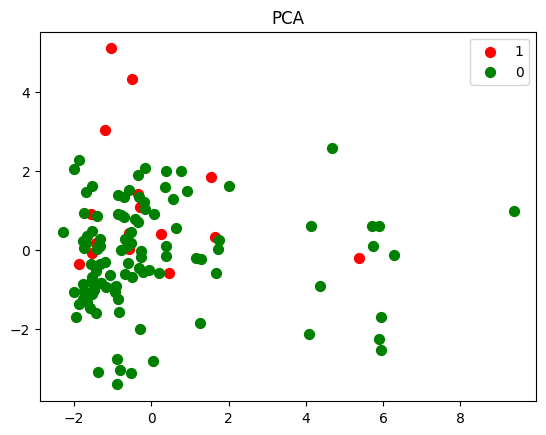

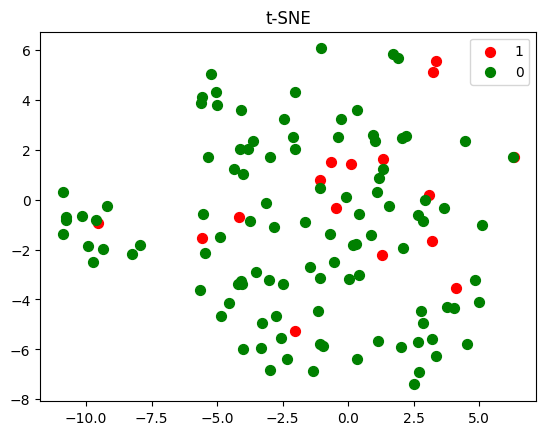

In [9]:
# dimensionality reduction and pattern analysis
# PCA
from sklearn.decomposition import PCA
from pandas import DataFrame, concat

data = pd.read_csv("data/scaled_zscore.csv", sep=";")
features = data.drop(columns=['death_aecopd'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = data['death_aecopd'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()


# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat

data = pd.read_csv("data/scaled_zscore.csv", sep=";")
features = data.drop(columns=['death_aecopd'])

X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = data['death_aecopd'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()


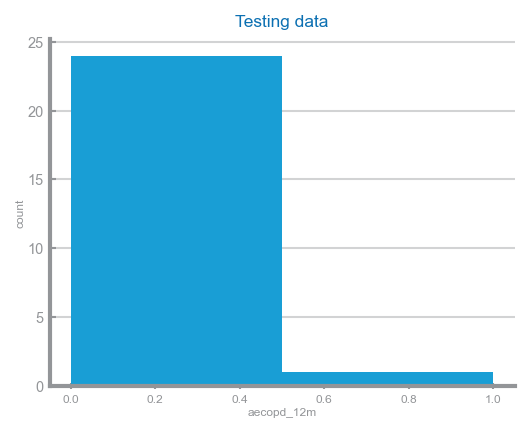

In [33]:
# plot how often each class of the target variable (death_aecopd) appears in the original, training and testing dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# read in data
data = pd.read_csv('data/scaled_minmax.csv', sep=";",na_values=None, header=0)

# plot original data
plt.clf()
plt.title('Original data')
plt.xlabel('death_aecopd')
plt.ylabel('count')
plt.hist(data['death_aecopd'], bins=2)
plt.savefig('images/original_data.svg', format='svg', dpi=1200)

# split data into training and testing data
from sklearn.model_selection import train_test_split
X = data.drop(columns=['death_aecopd', "death", "aecopd_12m"])
y = data['aecopd_12m'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# plot training data
plt.clf()
plt.title('Training data')
plt.xlabel('aecopd_12m')
plt.ylabel('count')
plt.hist(y_train, bins=2)
plt.savefig('images/training_data.svg', format='svg', dpi=1200)

# plot testing data
plt.clf()
plt.title('Testing data')
plt.xlabel('aecopd_12m')
plt.ylabel('count')
plt.hist(y_test, bins=2)
plt.savefig('images/testing_data.svg', format='svg', dpi=1200)


In [38]:
# radviz feature visualization


from sklearn.naive_bayes import GaussianNB
from yellowbrick.features.radviz import RadViz 

# k fold cross validation for each naive bayes, decision tree and random forest classifier



# sex	season	aecopd_12m	saturation	rr	sbp	dbp	hr	temperature	oedema	retractions	confusion	dyspnoea_yesno	dyspnoea_mMRC	age	fev1	bmi	rural	home_care	charlson	ami	heart_failure	cbd	pad	dementia	diabetes	cancer

# rad viz plot
features = ["sex", "season", "saturation", "rr", "sbp", "dbp", "hr", "temperature", "oedema", "retractions", "confusion", "dyspnoea_yesno", "dyspnoea_mMRC", "age", "bmi", "rural", "home_care", "charlson", "ami", "heart_failure", "cbd", "pad", "dementia", "diabetes", "cancer"]
classes = []

X =  data[features]
y = data['aecopd_12m']

visualizer = RadViz(classes=classes, features=features)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()


YellowbrickValueError: number of specified classes does not match number of unique values in target

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# import decision tree, random forest and svm classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define the classifiers you want to evaluate
classifiers = [DecisionTreeClassifier, RandomForestClassifier, SVC, GaussianNB, KNeighborsClassifier, MLPClassifier]

# Fold X 5 times
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# train and test each classifier
for classifier in classifiers:
    print("Classifier: ", classifier.__name__)
    accuracy = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = classifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
    print("Accuracy: ", accuracy)
    print("Mean accuracy: ", np.mean(accuracy))
    print("Standard deviation: ", np.std(accuracy))
    print("")

Classifier:  DecisionTreeClassifier
Accuracy:  [0.8, 0.6666666666666666, 0.6666666666666666, 0.7083333333333334, 0.7083333333333334]
Mean accuracy:  0.7100000000000001
Standard deviation:  0.04870546398734155

Classifier:  RandomForestClassifier
Accuracy:  [0.96, 0.7916666666666666, 0.875, 0.8333333333333334, 0.875]
Mean accuracy:  0.867
Standard deviation:  0.055831094482475536

Classifier:  SVC
Accuracy:  [0.92, 0.7916666666666666, 0.9166666666666666, 0.8333333333333334, 0.875]
Mean accuracy:  0.8673333333333334
Standard deviation:  0.04929052196473026

Classifier:  GaussianNB
Accuracy:  [0.52, 0.5833333333333334, 0.4166666666666667, 0.25, 0.2916666666666667]
Mean accuracy:  0.4123333333333334
Standard deviation:  0.1278784144759736

Classifier:  KNeighborsClassifier
Accuracy:  [0.92, 0.7916666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334]
Mean accuracy:  0.859
Standard deviation:  0.050789325212642435

Classifier:  MLPClassifier
Accuracy:  [0.92, 0.7916666666

In [ ]:
# confusion matrix

from numpy import ndarray
from sklearn.metrics import confusion_matrix

labels: ndarray = np.unique(y)
labels.sort()
prdY: ndarray = clf.predict(X_test)
cnf_mtx_tst: ndarray = confusion_matrix(y_test, prdY, labels=labels)
cnf_mtx_tst

import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None,
                          normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='y', horizontalalignment="center")

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[0,0])
plot_confusion_matrix(cnf_mtx_tst, labels, axs[0,1], normalize=True)
plt.show()

In [1]:
# ROC curve

data = pd.read_csv('data/scaled_zscore.csv', sep=";",na_values=None, header=0)

y = data.pop('death_aecopd').values
X = data.values
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
model = GaussianNB().fit(trnX, trnY)

# plot roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
lr_probs = model.predict_proba(tstX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(tstY, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(tstY, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

NameError: name 'pd' is not defined

In [ ]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, plot_overfitting_study
from sklearn.metrics import accuracy_score

file_tag = 'exaggerate'
filename = 'data/scaled_zscore'
target = 'death_aecopd'

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

eval_metric = accuracy_score
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    y_tst_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prd_tst_Y = knn.predict(tstX)
        y_tst_values.append(eval_metric(tstY, prd_tst_Y))
        if y_tst_values[-1] > last_best:
            best = (n, d)
            last_best = y_tst_values[-1]
    values[d] = y_tst_values

figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

FileNotFoundError: [Errno 2] No such file or directory: 'data/scaled_zscore_train.csv'